In [2]:
%%capture no-stderr
%pip install -q -U langgraph langchain-core langchain-community langchain-google-genai tavily-python yfinance

In [3]:
from google.colab import userdata

GEMINI_API_KEY = userdata.get("GEMINI_API_KEY")

In [4]:
import os

os.environ["LANGCHAIN_API_KEY"] = userdata.get("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

In [5]:
import os

os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')

In [6]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.checkpoint.memory import MemorySaver
import operator
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langgraph.graph.state import CompiledStateGraph
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, RemoveMessage, ToolMessage, AnyMessage
from langchain.agents import tool
from langgraph.prebuilt import ToolNode, tools_condition
from typing import Annotated, List
from typing_extensions import TypedDict
from IPython.display import display, Image
from langchain_community.tools.tavily_search import TavilySearchResults
import yfinance as yf

tavily_search = TavilySearchResults(max_results=3)

def get_stock_price(ticker: str) -> float:
    """Gets the previous closing price of a stock from Yahoo Finance.

    Args:
        ticker: The ticker symbol of the stock.

    Returns:
        The previous closing price as a float.
    """
    stock = yf.Ticker(ticker)
    previous_close = stock.info.get('previousClose', 0.0)
    return previous_close

def add(a: int, b: int) -> int:
    """Adds two integers."""
    return a + b

def subtract(a: int, b: int) -> int:
    """Subtracts two integers."""
    return a - b

def multiply(a: int, b: int) -> int:
    """Multiplies two integers."""
    return a * b

def divide(a: int, b: int) -> int:
    """Divides two integers. Raises ZeroDivisionError if the second number is zero."""
    if b == 0:
        raise ZeroDivisionError("Cannot divide by zero")
    return a // b

tools = [add, subtract, multiply, divide, tavily_search, get_stock_price]

In [7]:
llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(api_key=GEMINI_API_KEY, model="gemini-2.0-flash-exp")

llm_with_tools = llm.bind_tools(tools)

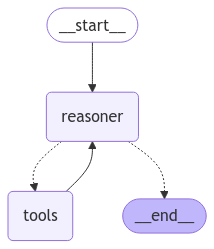

In [13]:
class State(TypedDict):
  messages: Annotated[List[AnyMessage], operator.add]

memory: MemorySaver = MemorySaver()

def reasoner(state: State):
  response = llm_with_tools.invoke(state["messages"])
  return {"messages": [response]}

builder = StateGraph(State)
builder.add_node("reasoner", reasoner)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "reasoner")
builder.add_conditional_edges("reasoner", tools_condition)
builder.add_edge("tools", "reasoner")

graph = builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
config = {"configurable": {"thread_id": 1}}

output = graph.invoke({"messages": [HumanMessage(content="WHat is the stock price of the car company of the worlds richest man?")]}, config)
for m in output['messages']:
    m.pretty_print()

================================ Human Message =================================

WHat is the stock price of the car company of the worlds richest man?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (430fb025-d769-48ae-ad7b-a1a0cb1877ea)
 Call ID: 430fb025-d769-48ae-ad7b-a1a0cb1877ea
  Args:
    query: who is the richest man in the world
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.moneycontrol.com/news/business/markets/elon-musk-still-the-richest-person-in-history-first-in-world-with-net-worth-over-400-billion-powered-by-tesla-spacex-12888104.html", "content": "Elon Musk still the richest person in history; first in world with net worth over $400 billion, powered by Tesla, SpaceX Elon Musk's fortune, estimated at over $400 billion by both Bloomberg and Forbes, gained remarkable momentum overnight."}, {"url": "https://www